# Numerical Exercise 04

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import math

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
names = ["solid", "liquid", "gas"]
files = ["kinetic_energy.dat", "potential_energy.dat", "total_energy.dat", "temperature.dat", "pressure.dat"]


## Assignment
### Exercise 04.1

The Molecular Dynamics / Monte Carlo (MD_MC) code we have provided compute the total (internal) energy per particle, $E/N$, the potential energy per particle, $U/N$, the kinetic energy per particle, $K/N$, and the temperature, $T$.

Include the calculation of the pressure, $P$, inside your Molecular Dynamics code: block averages, progressive average values and progresssive uncertainties.

Remember that, via the **virial theorem**, the pressure in a Lennard-Jones system can be estimated by means of:

$$ P = \rho k_B T + \frac{1}{3V} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 48\epsilon \left[ \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - 
\frac{1}{2} \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^6 \right] \right\rangle $$

### Exercise 04.2
By means of your upgraded code, perform MD simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

and show in pictures the obtained progressive average values and uncertainties as a functions of the increasing number of blocks for the total (internal) energy per particle, $E/N$, the potential energy per particle, $U/N$, the kinetic energy per particle, $K/N$, the temperature, $T$, and the pressure, $P$, in reduced units!

### Equilibration is needed!

By monitoring the temperature, $T$, during the first time steps of the simulation, you will observe that at the beginning, starting from a perfect crystalline configuration, $T$ will not conserve its value. Can you understand and explain this behaviour?

Explore and find the starting value of $T$ needed to stabilize, after a certain number of time steps (equilibration time), the average value of $T$ on the desired $T^\star$. Perform your solid/liquid phase MD simulations by re-starting them after such equilibration time.

## Resolution
<!-- add equilibration somewhere -->
### Molecular Dyanamics

#### Some Thermodynamics
The goal of statistical physics is to predict macroscopic properties of a system by studying the microscopic properties of its constituents. By describing a system by its macrostate, for example the total energy, the system could be in any one of the microstates that correspond to that macrostate.
Each microstates is characterized by the same macrostate. An ensemble is a collection of microstates that have the same macrostate.

In this exercise and the next few ones we will work with the microcanonical ensemble, which is an ensemble of systems that have the same energy. Physically we are studying an isolated system, so the energy is conserved. The microcanonical ensemble is also called the NVE ensemble, because the number of particles, volume and energy are conserved.

#### Simulation
The NSL Simulator code provides an "exact" approch to the microcanonical ensemble. It thus computes the motion of each particle according to the Newton's equations of motion. To simulate this, the program employs the Verlet algorithm, which is a numerical method used to efficiently integrate equations of motion. It is based on a third order expansion of the position of the particles $r(t)$ around the time $t \pm \delta t$.
The Verlet algorihtm is defined as:
$$
r(t + \delta t) = 2r(t) - r(t - \delta t) + a(t)\delta t^2
$$
where $a(t)$ is the acceleration of the particle at time $t$.

This algorithm needs the initial position and velocity of the particles to start the simulation. Additionally, this algorihtm does not use the velocity of the particles to compute the new position. Therefore, the velocity of the particles is computed as:
$$
v(t) = \frac{r(t + \delta t) - r(t - \delta t)}{2\delta t}
$$
so, to compute the velocity of the particles at time $t$, we need the position of the particles at times $t + \delta t$ and $t - \delta t$.

<!-- add pbc? -->
<!-- add cut-off range/minimum image convention? -->


### Code
I tried to avoid modifying excessively the code provided, but I added some methods to initiliaze the simulator and the system properties at runtime, and without the need to read from file. I also added some sort of "switches" for generatering output files and methods to access directly the computed averages, so that I could extract and format as I saw fit.
<!-- add examples -->
I also leveraged parallel processisng to run many simulations in parallel, using `openMP`.
By summing all these changes, the code may processed garbled outputs but they are not used in the final analysis or the data collection.

#### Pressure implementation
In the code, pressure is computed inside the `measure` method. According to the provided formula and using L-J units, the pressure is computed as:
$$
P^* = \rho^* T^* + \frac{1}{3V^*} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 48 \left[ \left(\frac{1}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - \frac{1}{2} \left(\frac{1}{|\vec{r}_i -\vec{r}_j|}\right)^6 \right] \right\rangle
$$
which, in the code, is computed as:
```cpp
void System :: measure(){ // Measure properties
    /* some variables initialization... */  
    _measurement.zeros();
    double virial_temp = 0.0;
    double virial=0.0;
    if (_measure_penergy or _measure_pressure or _measure_gofr) {
        for (int i=0; i<_npart-1; i++){
            for (int j=i+1; j<_npart; j++){
                /* other code... */
                if(dr < _r_cut){
                    if(_measure_penergy)  penergy_temp += 1.0/pow(dr,12) - 1.0/pow(dr,6); // POTENTIAL ENERGY
                    if(_measure_pressure) virial_temp += 1.0/pow(dr,12) - 0.5/pow(dr,6); // PRESSURE ... TO BE FIXED IN EXERCISE 4 
                }
            }
        }
    }
    /* other code... */
    // PRESSURE //////////////////////////////////////////////////////////////////
    if (_measure_pressure){
    virial = 48.0 * virial_temp / (3.0 * double(_npart));
    _measurement(_index_pressure) = _rho * _measurement(_index_temp) + virial / _volume;
    }
    /* ohter code... */
    _block_av += _measurement; //Update block accumulators

    return;
}
```

<!-- second exercise: explain the codes as in the readme file and why it is needed -->


50000
50000
500000
Solid : Initial temperature needed for target temperature 0.8 is 1.54
Check: 0.8
Liquid : Initial temperature needed for target temperature 1.1 is 1.98
Check: 1.1
Gas : Initial temperature needed for target temperature 1.2 is 0.95
Check: 1.2


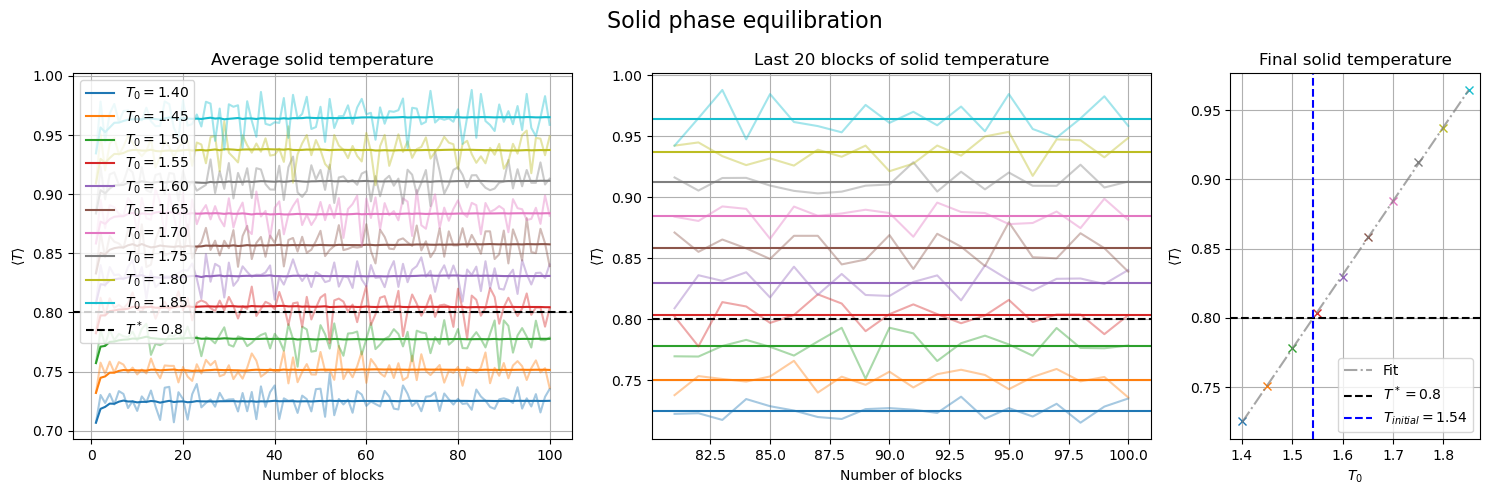

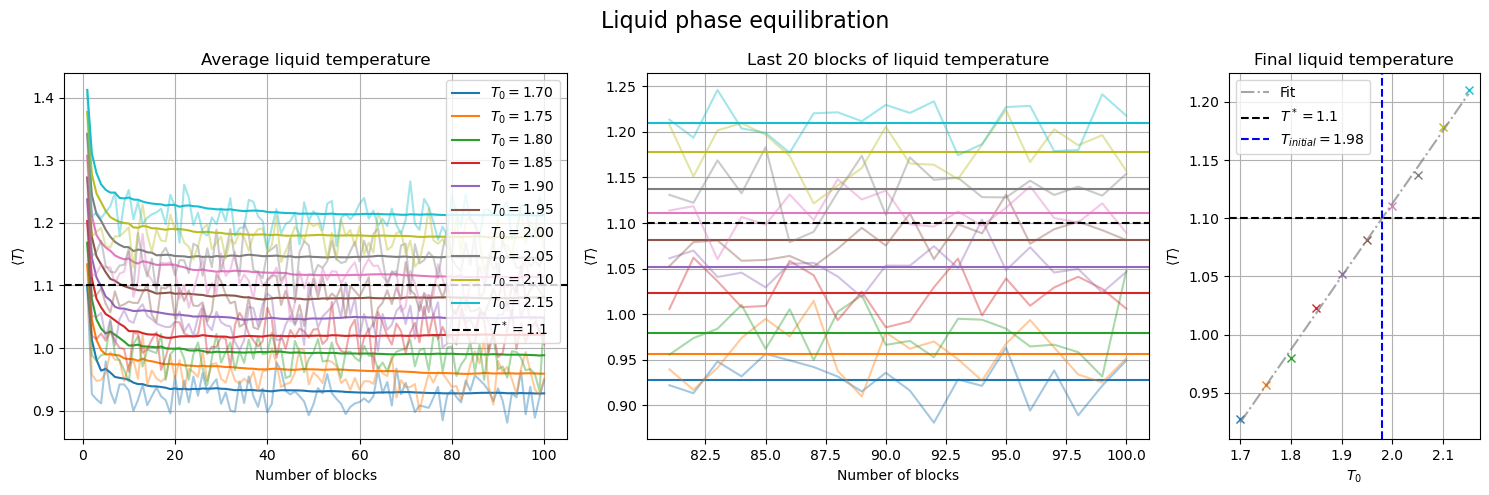

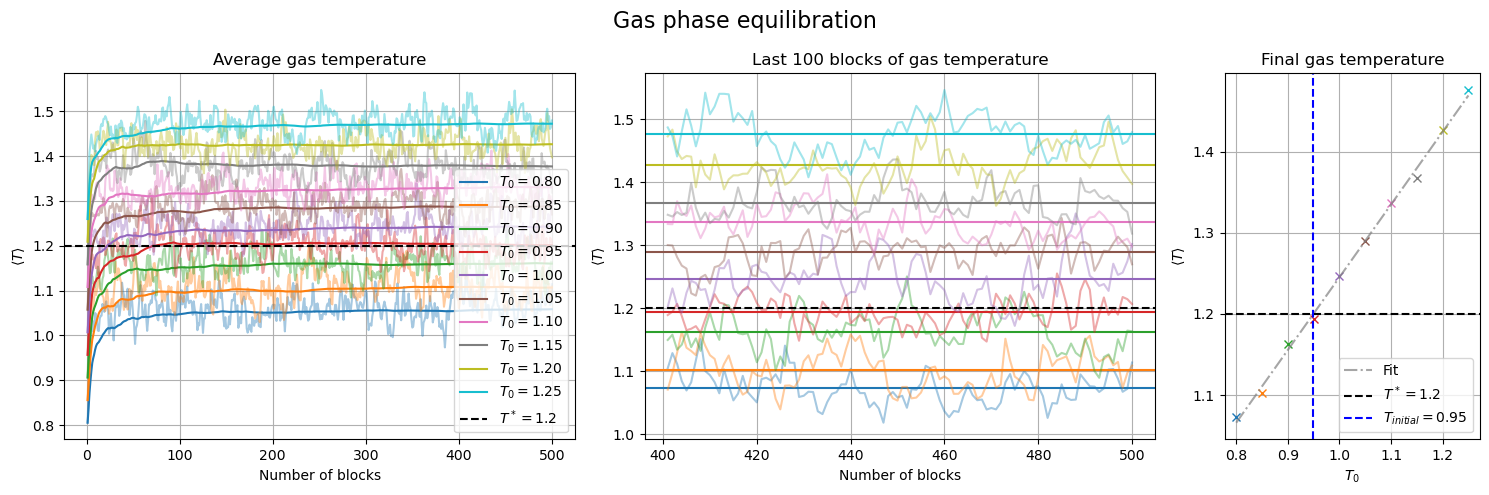

In [6]:

target_temp = [0.8, 1.1, 1.2]
t0 = np.zeros(10)
avgs = np.zeros(10)
last_blocks = [20, 20, 100]
fit_line = []
for name in names:
    gs = gridspec.GridSpec(1, 3, width_ratios=[2,2,1])
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    graphs = [ax1, ax2, ax3]
    fig.suptitle(name.capitalize()+" phase equilibration", fontsize=16)
    for i in range(10):
        starting_temp, n_throws, blck_avg, cum_avg, errors = np.loadtxt("../data/ex04_eq_"+name+"_"+str(i)+".dat", unpack=True, usecols=(0,1,2,3,4))
        label = r"$T_{initial}={temp:.2f}$".format(initial="{0}", temp=starting_temp[1]) 
        t0[i] = starting_temp[1]
        avgs[i] = np.mean(blck_avg[-last_blocks[names.index(name)]:])
        graphs[0].plot(n_throws, blck_avg, color=colors[i] , alpha=0.4)
        graphs[0].plot(n_throws, cum_avg, label=label, color=colors[i])
        graphs[2].plot(t0[i], avgs[i], marker='x')
        graphs[1].plot(n_throws[-last_blocks[names.index(name)]:], blck_avg[-last_blocks[names.index(name)]:], label=label, color=colors[i], alpha=0.4)
        graphs[1].axhline(np.mean(blck_avg[-last_blocks[names.index(name)]:]), label=label, color=colors[i])
    fit_coeffs = np.polyfit(t0, avgs, 1)
    fit_line.append(np.poly1d(fit_coeffs))
    target_label = r"$T^*={temp}$".format(temp=str(target_temp[names.index(name)]))
    graphs[2].plot(t0, fit_line[names.index(name)](t0), color='gray', alpha = 0.7 , linestyle='-.', label="Fit")
    graphs[0].axhline(y=target_temp[names.index(name)], color='black', linestyle='--', label=target_label)
    graphs[1].axhline(y=target_temp[names.index(name)], color='black', linestyle='--', label=target_label)
    graphs[2].axhline(y=target_temp[names.index(name)], color='black', linestyle='--', label=target_label)
    intial_temp = (fit_line[names.index(name)] - target_temp[names.index(name)]).roots
    graphs[2].axvline(x=intial_temp[0], color='b', linestyle='--', label=r"$T_{initial}" + "={temp:.2f}$".format(temp=intial_temp[0]))
    graphs[0].set_title("Average "+name+" temperature")
    graphs[0].set_xlabel('Number of blocks')
    graphs[0].set_ylabel(r"$\langle T \rangle$")
    graphs[0].grid(True)
    graphs[0].legend()
    graphs[2].set_title("Final "+name+" temperature")
    graphs[2].set_xlabel(r"$T_{0}$")
    graphs[2].set_ylabel(r"$\langle T \rangle$")
    graphs[2].grid(True)
    graphs[2].legend()
    graphs[1].set_title("Last {0} blocks of {1} temperature".format(last_blocks[names.index(name)], name))
    graphs[1].set_xlabel('Number of blocks')
    graphs[1].set_ylabel(r"$\langle T \rangle$")
    graphs[1].grid(True)
    plt.tight_layout()

blcks = [100, 100, 500]
steps = [500, 500, 1000]
for b in blcks:
    print(b*steps[blcks.index(b)])

for target in target_temp:
    intial_temp = (fit_line[target_temp.index(target)] - target).roots
    name = names[target_temp.index(target)].capitalize()
    print("{2} : Initial temperature needed for target temperature {0} is {1:.2f}".format(target, intial_temp[0], name))
    print("Check: {0}".format(fit_line[target_temp.index(target)](intial_temp[0])))


plt.show()




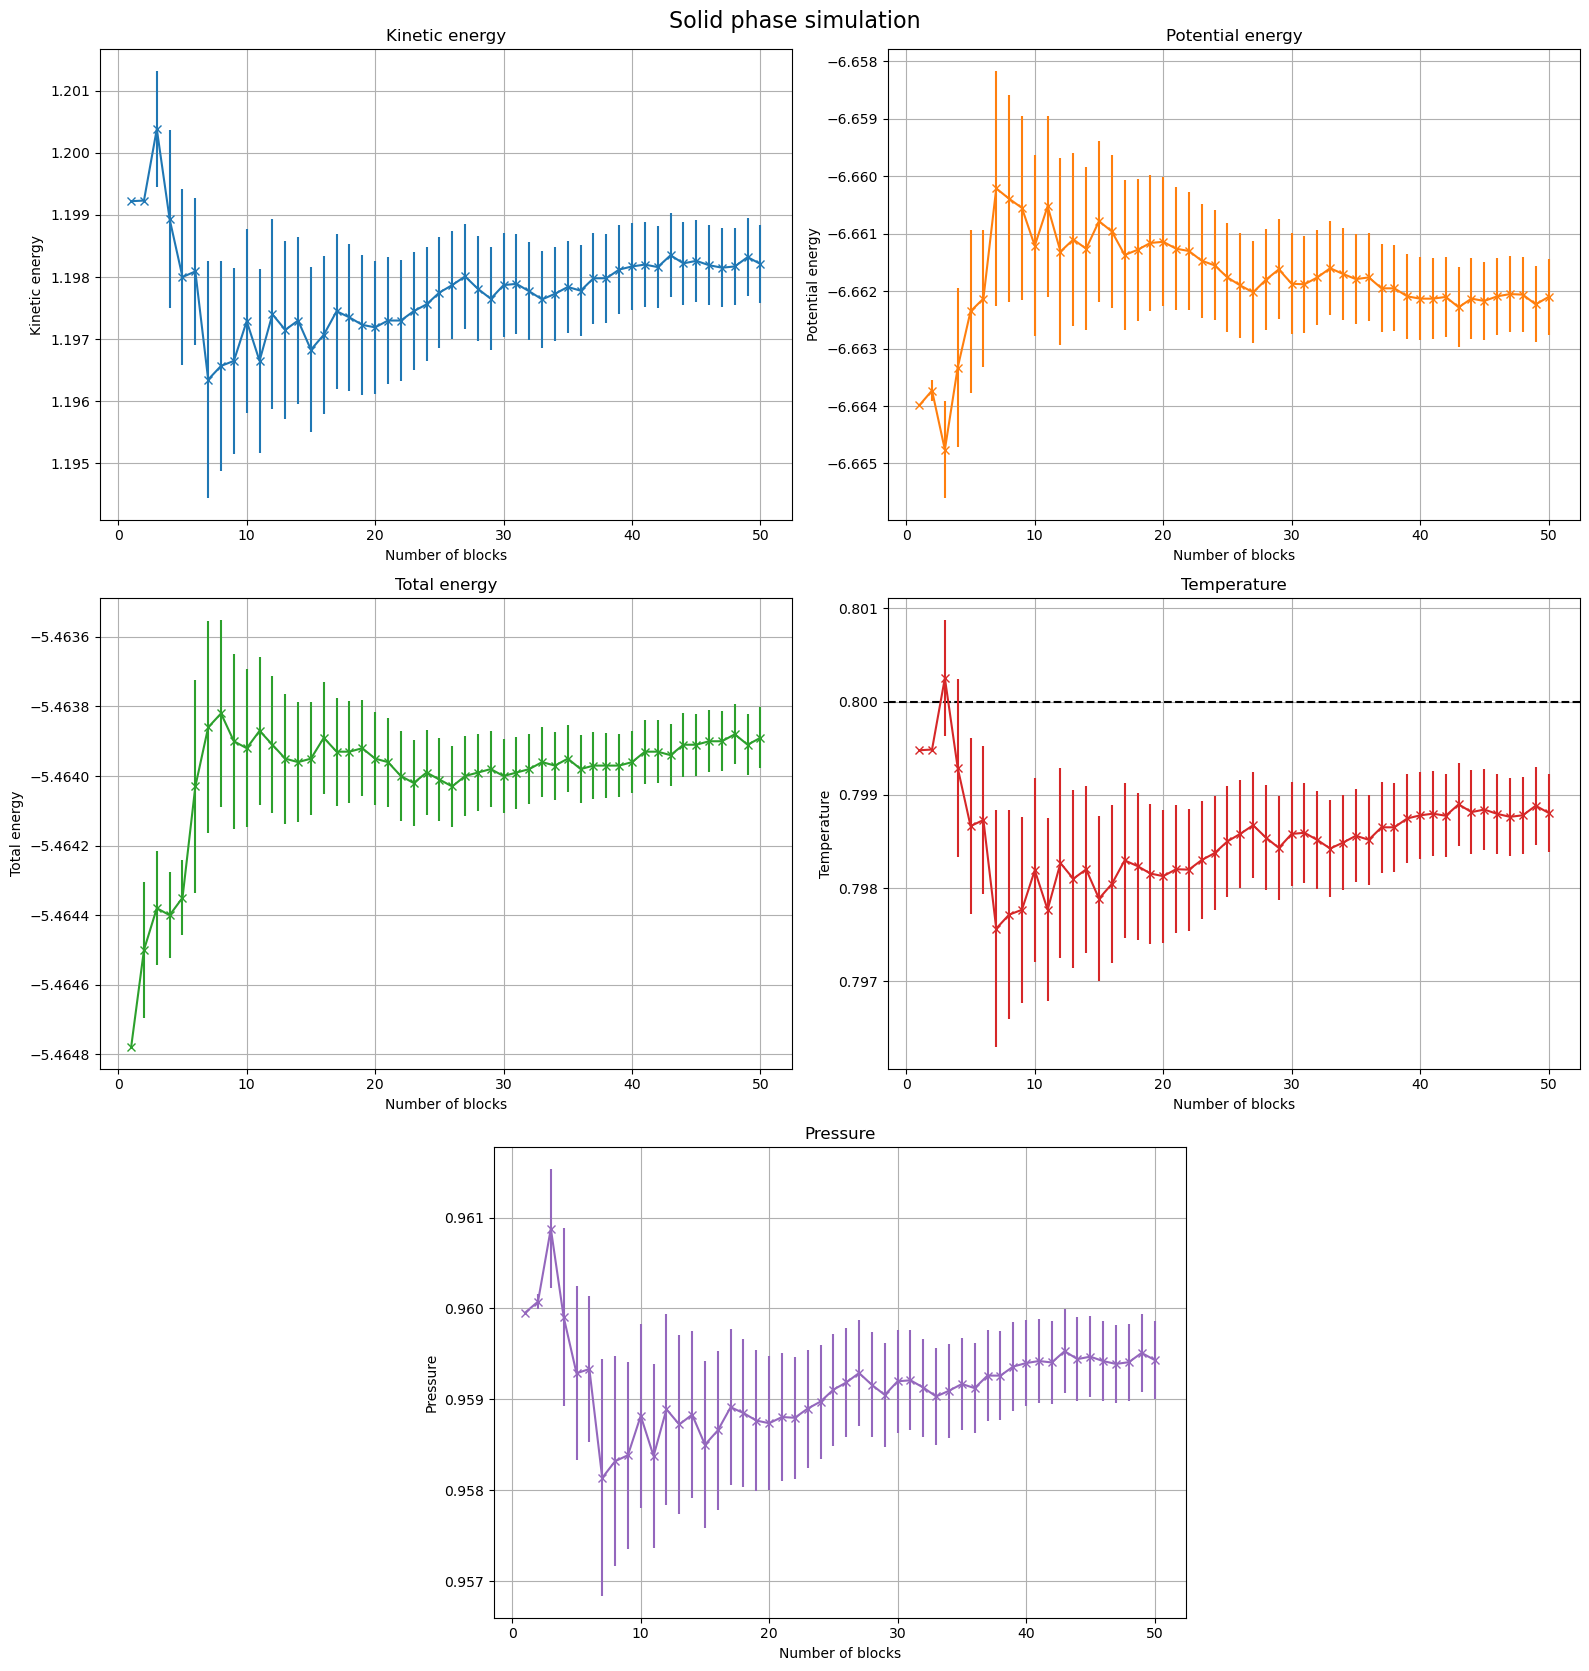

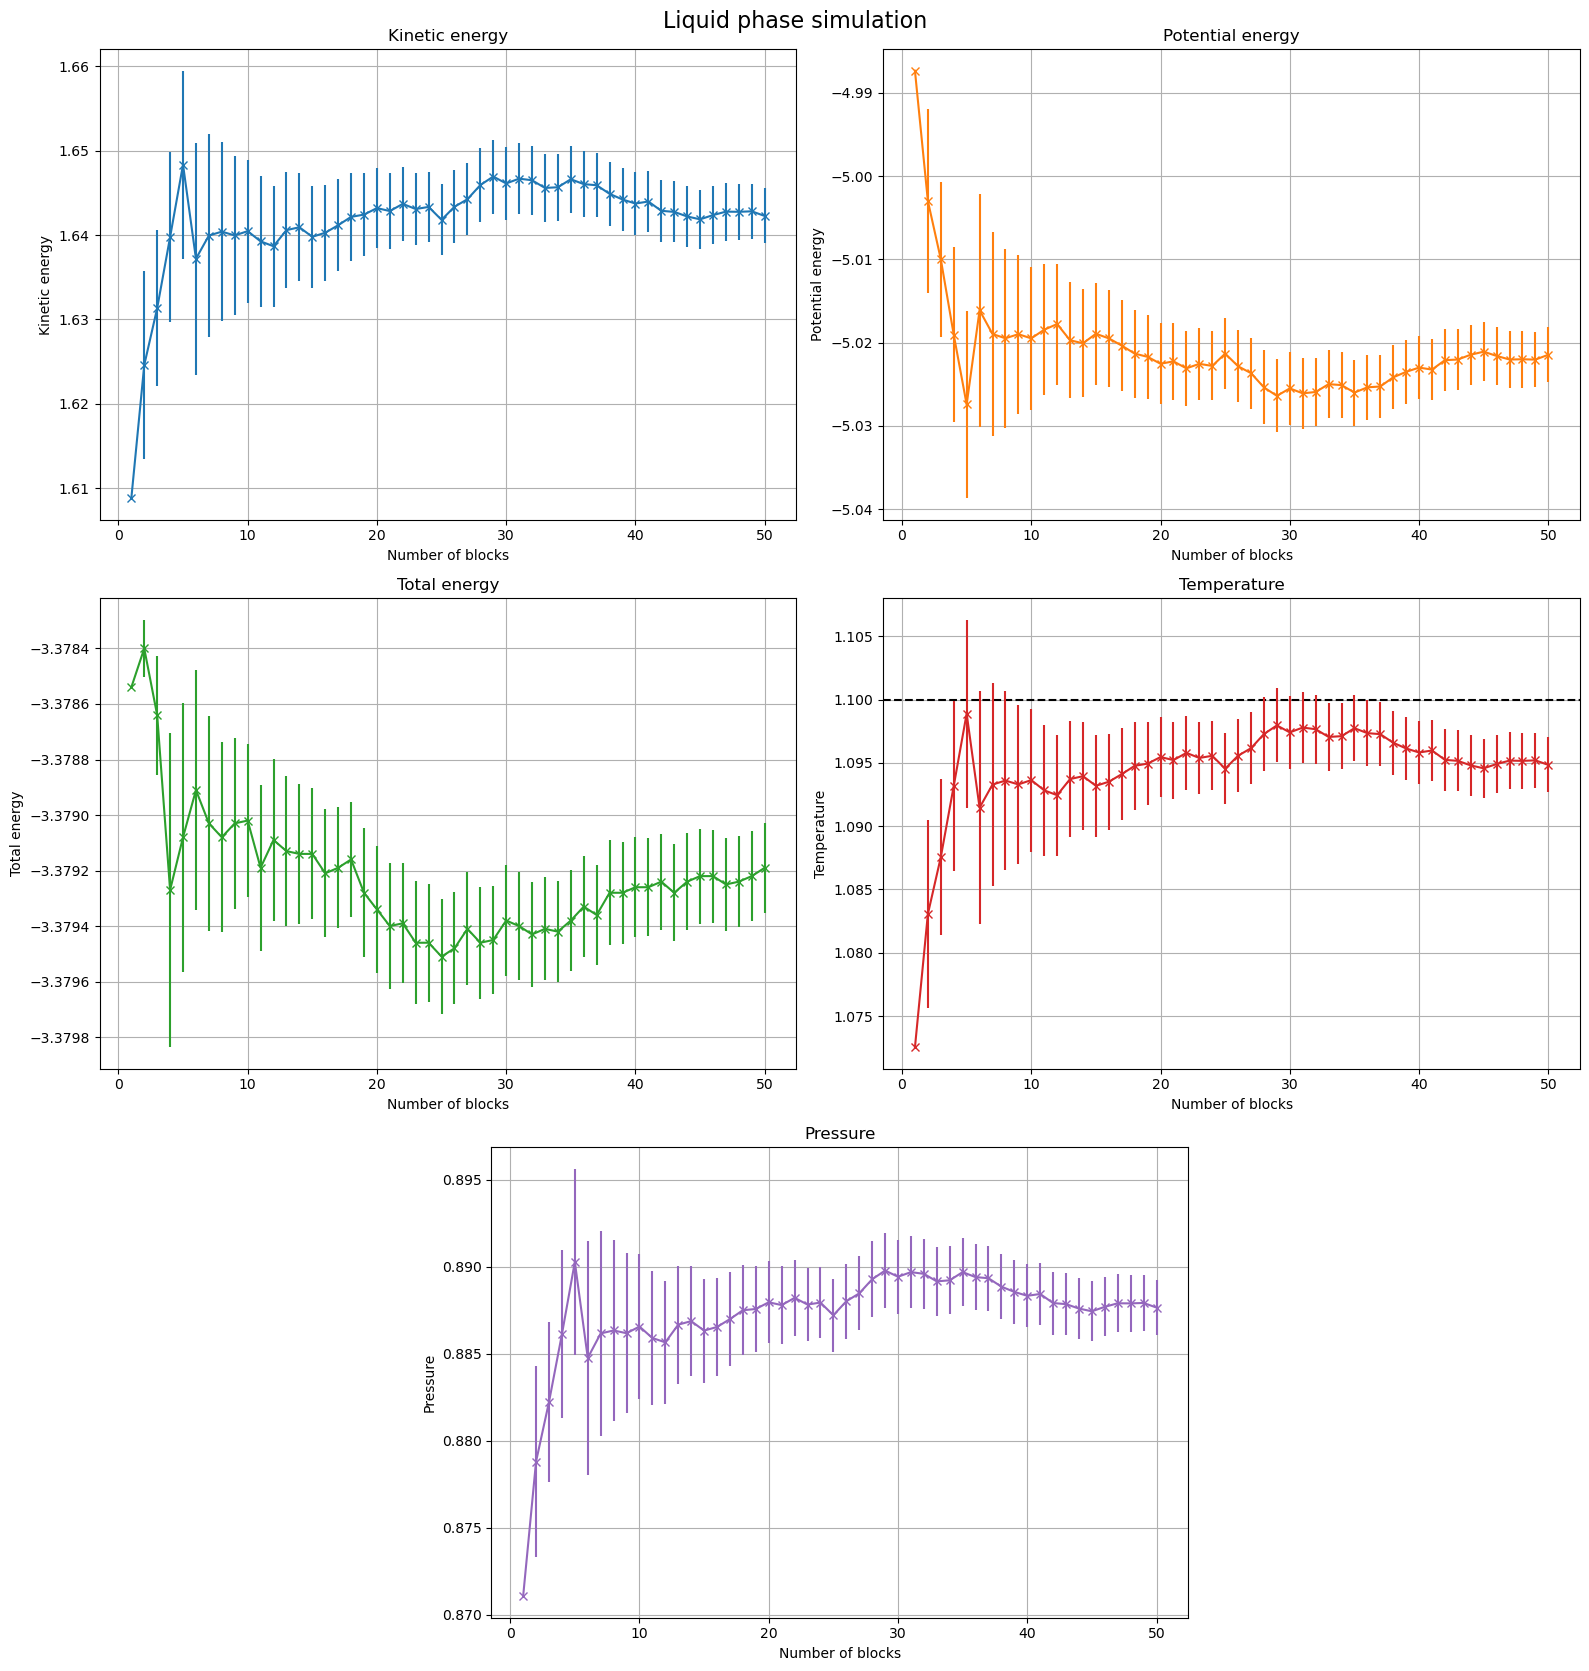

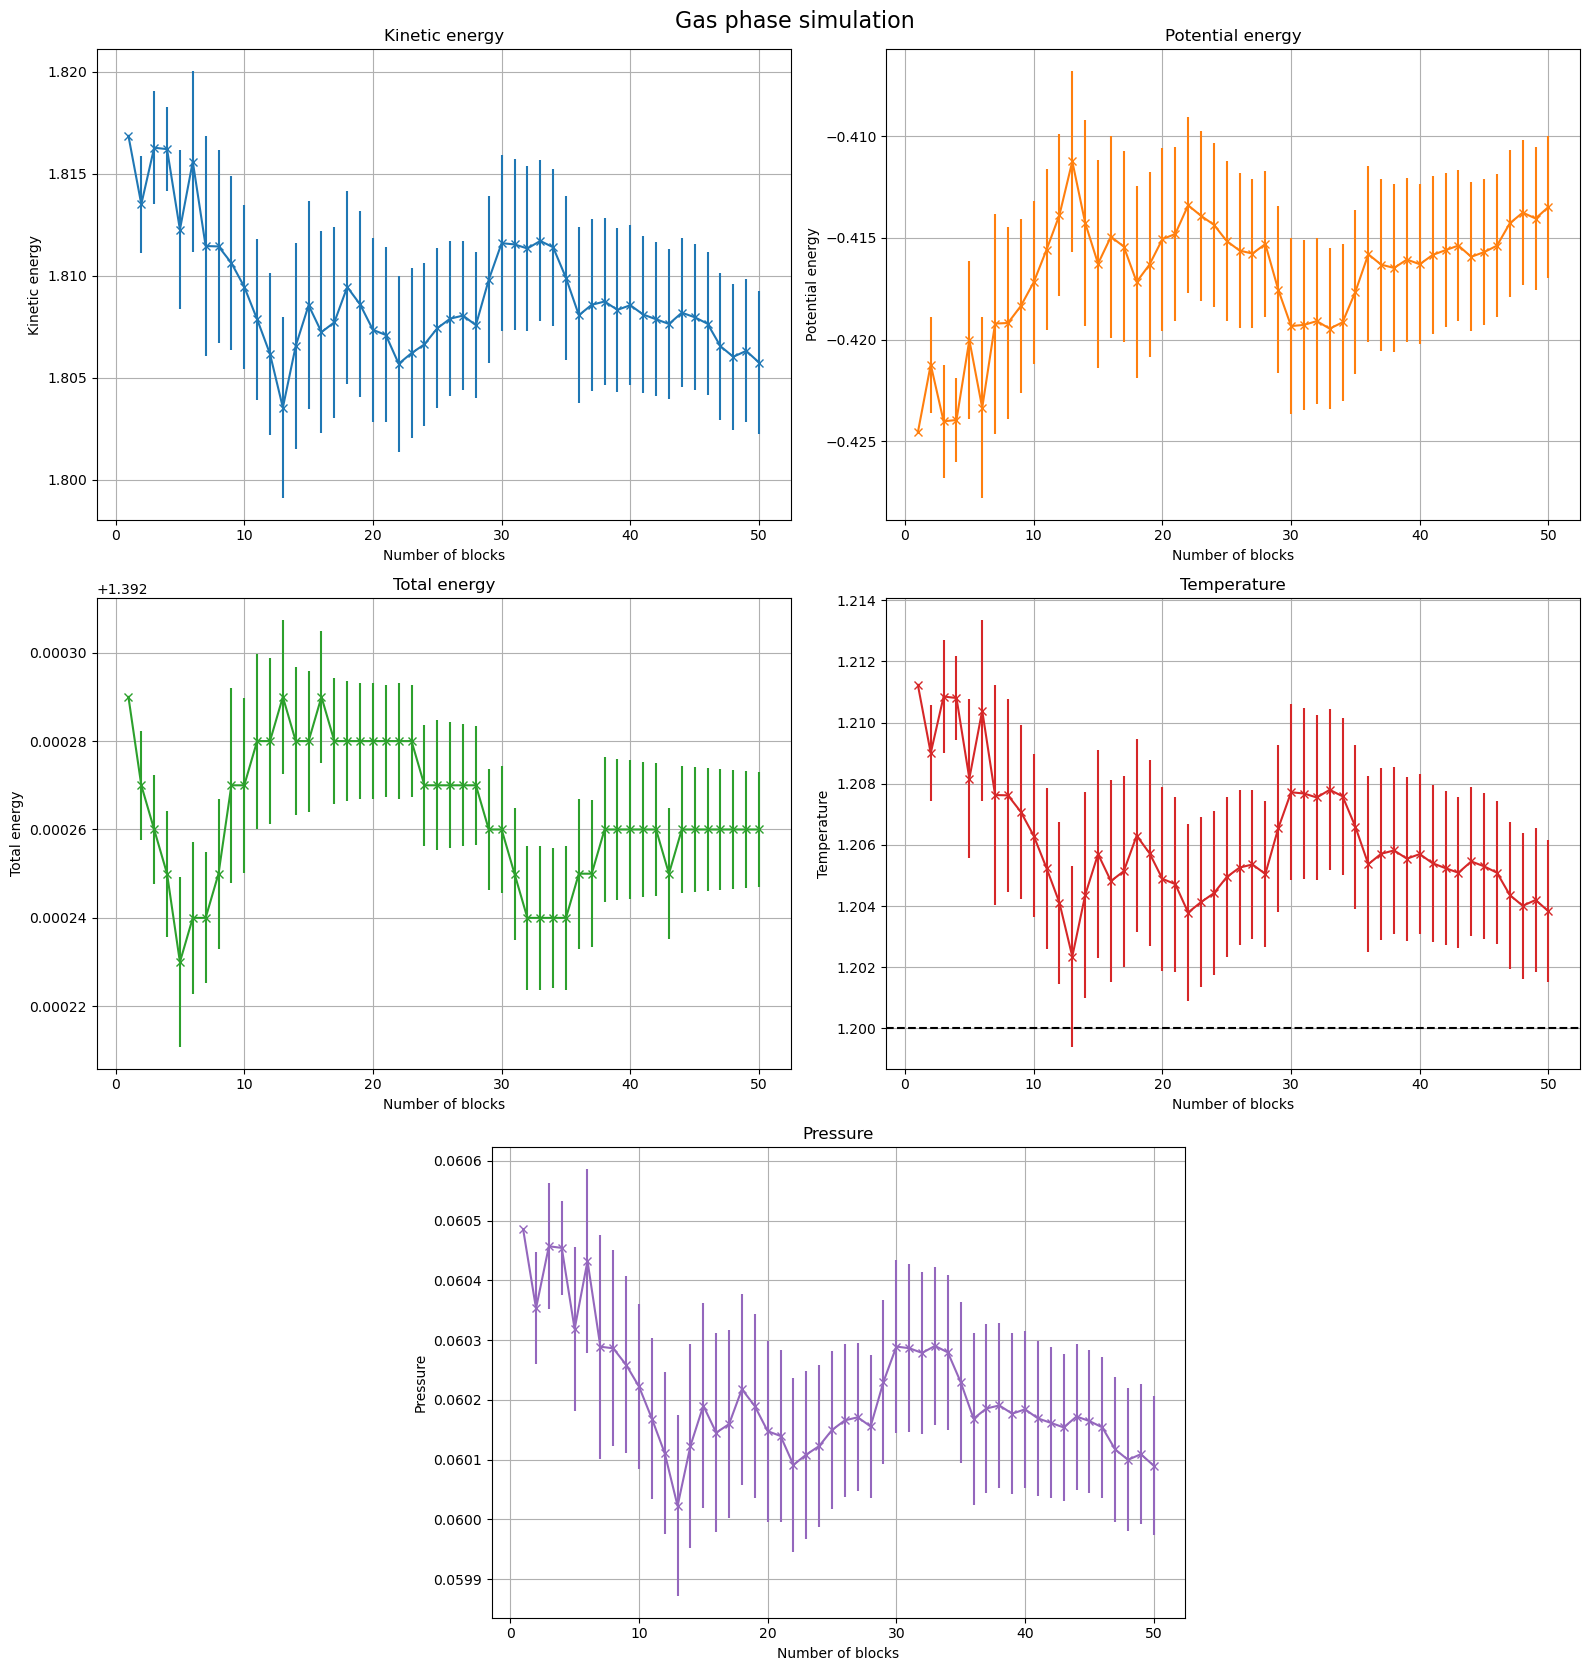

In [7]:
for name in names:
    gs = gridspec.GridSpec(3, 4)
    fig = plt.figure(figsize=(16, 17))
    fig.suptitle(name.capitalize()+" phase simulation", fontsize=16)
    ax1 = fig.add_subplot(gs[0, 0:2])
    ax2 = fig.add_subplot(gs[0, 2:4])
    ax3 = fig.add_subplot(gs[1, 0:2])
    ax4 = fig.add_subplot(gs[1, 2:4])
    ax5 = fig.add_subplot(gs[2, 1:3])
    graphs = [ax1, ax2, ax3, ax4, ax5]
    graphs[3].axhline(y=target_temp[names.index(name)], color='black', linestyle='--', label="Target temperature")
    basefilename = "../data/ex04/OUTPUT_"+name.upper()
    for i, file in enumerate(files):
        n_blck, actual, avg, error = np.loadtxt(basefilename+"/"+file, unpack=True, usecols=(0,1,2,3), skiprows=1)
        label = ((file.split('.')[0]).replace('_', ' ')).capitalize()
        graphs[i].errorbar(n_blck, avg, yerr=error, label=label, color=colors[i], marker='x')
        graphs[i].set_title(label)
        graphs[i].set_xlabel('Number of blocks')
        graphs[i].set_ylabel(label)
        graphs[i].grid(True)
    plt.tight_layout()
    plt.show()



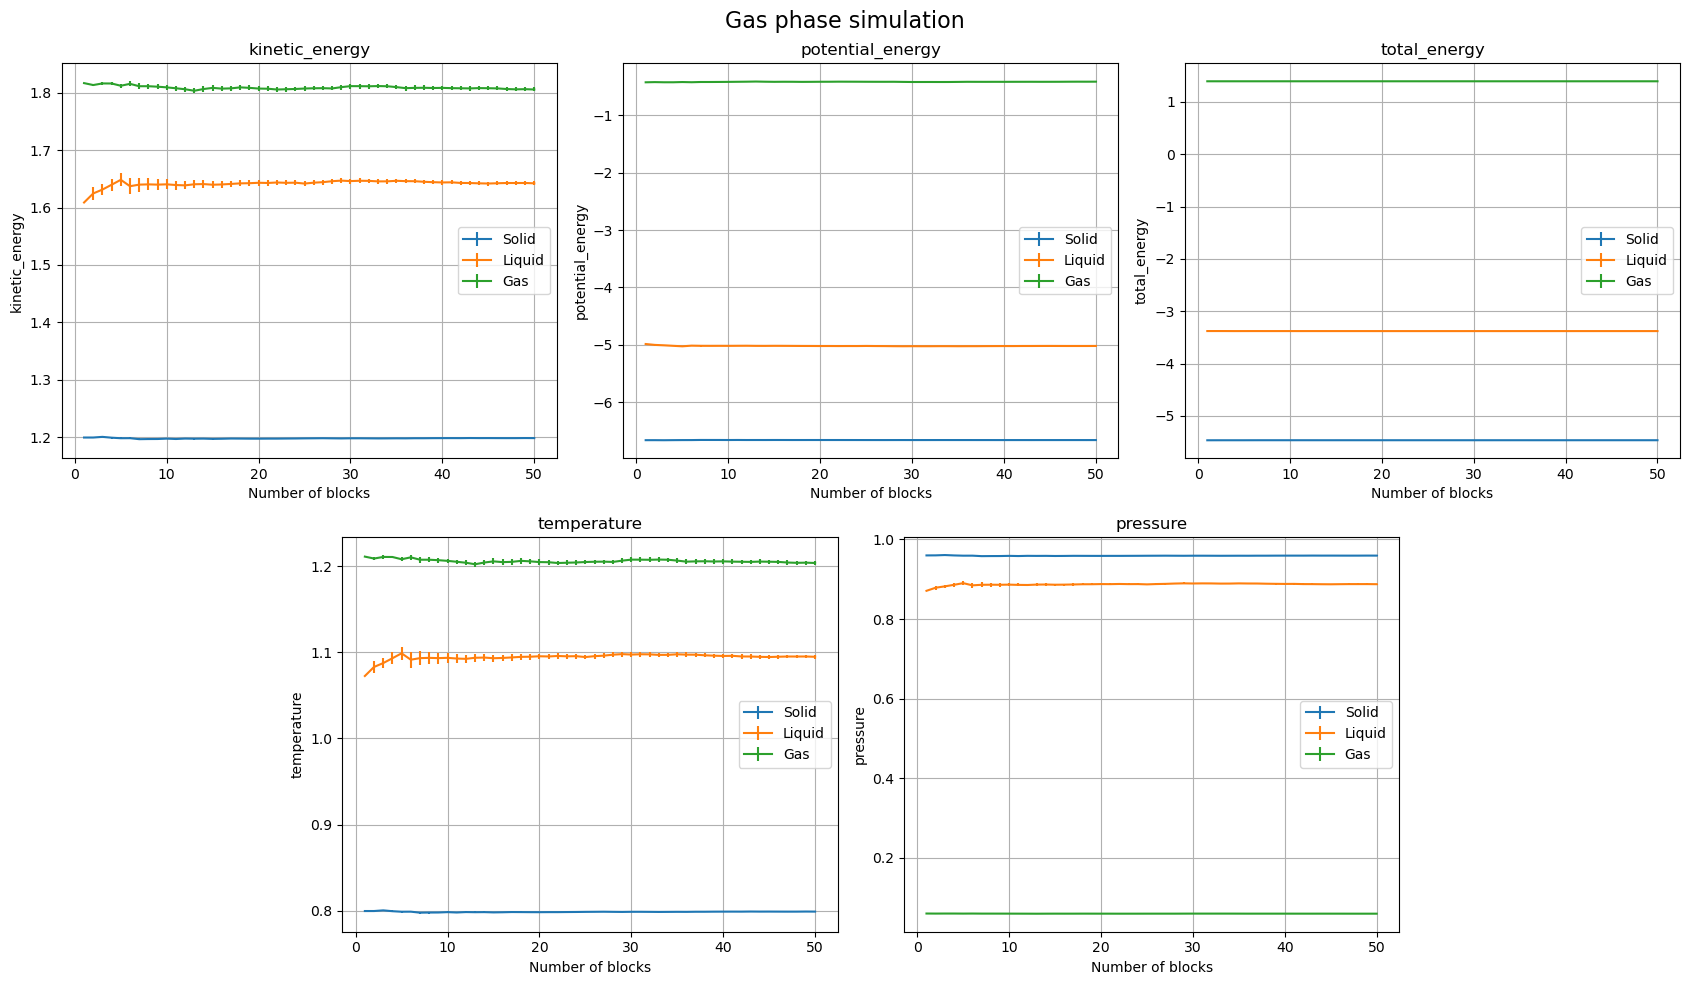

In [8]:

gs = gridspec.GridSpec(2, 6)
fig = plt.figure(figsize=(17, 10))
fig.suptitle(name.capitalize()+" phase simulation", fontsize=16)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])
graphs = [ax1, ax2, ax3, ax4, ax5]

for i, file in enumerate(files):
    for j, name in enumerate(names):
        basefilename = "../data/ex04/OUTPUT_"+name.upper()
        n_blck, actual, avg, error = np.loadtxt(basefilename+"/"+file, unpack=True, usecols=(0,1,2,3), skiprows=1)
        graphs[i].errorbar(n_blck, avg, yerr=error, label=name.capitalize(), color=colors[j])
        graphs[i].set_title(file.split('.')[0])
        graphs[i].set_xlabel('Number of blocks')
        graphs[i].set_ylabel(file.split('.')[0])
        graphs[i].grid(True)
    graphs[i].legend()
plt.tight_layout()
plt.show()

